In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import sklearn
import pandas as pd
import scipy.stats as stats
import glob

#from keras import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasRegressor

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import sklearn.mixture
from sklearn.linear_model import LogisticRegression



In [5]:
neuron_data = {}

no_of_testfiles = 5

files = sorted(glob.glob('../neuron_logs/train_data/*.json'))
print(files)
print(len(files))

['../neuron_logs/train_data/output_tmp_20191217-185451.json', '../neuron_logs/train_data/output_tmp_20191217-185454.json', '../neuron_logs/train_data/output_tmp_20191217-185500.json', '../neuron_logs/train_data/output_tmp_20191217-185505.json', '../neuron_logs/train_data/output_tmp_20191217-185510.json', '../neuron_logs/train_data/output_tmp_20191217-185515.json', '../neuron_logs/train_data/output_tmp_20191217-185520.json', '../neuron_logs/train_data/output_tmp_20191217-185525.json', '../neuron_logs/train_data/output_tmp_20191217-185531.json', '../neuron_logs/train_data/output_tmp_20191217-192822.json', '../neuron_logs/train_data/output_tmp_20191217-192843.json', '../neuron_logs/train_data/output_tmp_20191217-192850.json', '../neuron_logs/train_data/output_tmp_20191217-192907.json', '../neuron_logs/train_data/output_tmp_20191217-193031.json', '../neuron_logs/train_data/output_tmp_20191217-193104.json', '../neuron_logs/train_data/output_tmp_20191217-193112.json', '../neuron_logs/train_d

In [3]:
def reduce_to_statistics(activations, labels, debug=False):
    sorted_data = []
    for i in range(10): #hardcoded MOFO
        sorted_data += [[]]
    for i, a in zip(labels, activations):
        sorted_data[i] += [a]
    if debug:
        return(sorted_data)
    statistics = []
    for ar in sorted_data:
        curr_stats = stats.describe(ar)
        statistics += [curr_stats.mean, curr_stats.variance, curr_stats.skewness, curr_stats.kurtosis, curr_stats.minmax[0],
                       curr_stats.minmax[1], curr_stats.nobs]
        #print(statistics)
    return(statistics)

def weight_statistics(weights):
    stats = []
    

In [4]:
filename = files[0]
with open(filename, 'r') as f:
    print(filename)
    neuron_data = json.load(f)

../neuron_logs/train_data/output_tmp_20191217-185451.json


In [5]:
np.percentile(neuron_data['5']['3 20']['input_weights'], 10)

-0.11922008618712425

In [6]:
ex = np.array(neuron_data['5']['3 20']['input_weights'])
gmm = sklearn.mixture.GaussianMixture(n_components = 5, covariance_type = 'diag')
gmm.fit(ex.reshape(-1, 1))

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [12]:
gmm.weights_

array([0.15766252, 0.20535913, 0.26048986, 0.20551476, 0.17097373])

(array([3., 4., 2., 7., 4., 4., 4., 4., 5., 8., 6., 5., 6., 6., 3., 7., 2.,
        7., 6., 7.]),
 array([-0.1728957 , -0.15521967, -0.13754364, -0.11986761, -0.10219158,
        -0.08451555, -0.06683952, -0.04916349, -0.03148746, -0.01381143,
         0.0038646 ,  0.02154063,  0.03921666,  0.05689269,  0.07456872,
         0.09224475,  0.10992078,  0.12759681,  0.14527284,  0.16294887,
         0.1806249 ]),
 <a list of 20 Patch objects>)

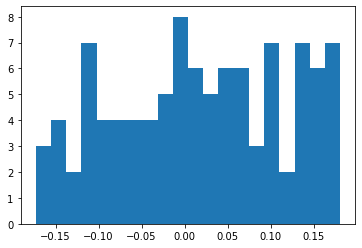

In [10]:
plt.hist(ex, bins = 20)

In [6]:
features, labels = [], []
target = 'usefulness_loss'

for i, filename in enumerate(files[no_of_testfiles:]):
    with open(filename, 'r') as f:
        print(filename)
        neuron_data = json.load(f)
    for e in neuron_data.keys():
        for neuron in neuron_data[e]:
            if ' ' not in neuron:
                continue
            current_data = neuron_data[e][neuron]
            important_features = []
            important_features = current_data['activations']
            # important_features += reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'])
            important_features += [current_data['depth']]
            important_features += [current_data['inverse_depth']]
            important_features += [current_data['width']]
            important_features += [np.percentile(current_data['input_weights'], p) for p in range(0, 101, 5)]
            important_features += [np.percentile(current_data['output_weights'], p) for p in range(0, 101, 5)]
            gmm_input = sklearn.mixture.GaussianMixture(n_components = 5, covariance_type = 'diag').fit(np.array(current_data['input_weights']).reshape(-1, 1))
            gmm_output = sklearn.mixture.GaussianMixture(n_components = 5, covariance_type = 'diag').fit(np.array(current_data['output_weights']).reshape(-1, 1))
            important_features += list(gmm_input.means_.flatten()) + list(gmm_input.covariances_.flatten()) + list(gmm_input.weights_)
            important_features += list(gmm_output.means_.flatten()) + list(gmm_output.covariances_.flatten()) + list(gmm_output.weights_)
            important_features += sorted(current_data['input_weights'])[:10]
            important_features += sorted(current_data['input_weights'])[-10:]
            important_features += sorted(current_data['output_weights'])[:10]
            important_features += sorted(current_data['output_weights'])[-10:]
            important_features += [current_data['reg_loss_in_layer']]
            important_features += [e]
            features += [important_features]
            #labels += [current_data[target]]
            labels += [current_data[target]]

../neuron_logs/train_data/output_tmp_20191217-185515.json
../neuron_logs/train_data/output_tmp_20191217-185520.json
../neuron_logs/train_data/output_tmp_20191217-185525.json
../neuron_logs/train_data/output_tmp_20191217-185531.json
../neuron_logs/train_data/output_tmp_20191217-192822.json
../neuron_logs/train_data/output_tmp_20191217-192843.json
../neuron_logs/train_data/output_tmp_20191217-192850.json
../neuron_logs/train_data/output_tmp_20191217-192907.json
../neuron_logs/train_data/output_tmp_20191217-193031.json
../neuron_logs/train_data/output_tmp_20191217-193104.json
../neuron_logs/train_data/output_tmp_20191217-193112.json
../neuron_logs/train_data/output_tmp_20191217-193115.json
../neuron_logs/train_data/output_tmp_20191217-193204.json
../neuron_logs/train_data/output_tmp_20191217-200153.json
../neuron_logs/train_data/output_tmp_20191217-200246.json
../neuron_logs/train_data/output_tmp_20191217-200305.json
../neuron_logs/train_data/output_tmp_20191217-200308.json
../neuron_logs

In [12]:
def extract_data(filename, target = 'usefulness_loss', shuffle = True):
    
    features, labels = [], []
    with open(filename, 'r') as f:
        neuron_data = json.load(f)
        for e in neuron_data.keys():
            for neuron in neuron_data[e]:
                if ' ' not in neuron:
                    continue
                current_data = neuron_data[e][neuron]
                important_features = []
                important_features = current_data['activations']
                #important_features += reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'])
                important_features += [current_data['depth']]
                important_features += [current_data['inverse_depth']]
                important_features += [current_data['width']]
                important_features += [np.percentile(current_data['input_weights'], p) for p in range(0, 101, 5)]
                important_features += [np.percentile(current_data['output_weights'], p) for p in range(0, 101, 5)]
                gmm_input = sklearn.mixture.GaussianMixture(n_components = 5, covariance_type = 'diag').fit(np.array(current_data['input_weights']).reshape(-1, 1))
                gmm_output = sklearn.mixture.GaussianMixture(n_components = 5, covariance_type = 'diag').fit(np.array(current_data['output_weights']).reshape(-1, 1))
                important_features += list(gmm_input.means_.flatten()) + list(gmm_input.covariances_.flatten()) + list(gmm_input.weights_)
                important_features += list(gmm_output.means_.flatten()) + list(gmm_output.covariances_.flatten()) + list(gmm_output.weights_)
                important_features += sorted(current_data['input_weights'])[:10]
                important_features += sorted(current_data['input_weights'])[-10:]
                important_features += sorted(current_data['output_weights'])[:10]
                important_features += sorted(current_data['output_weights'])[-10:]
                important_features += [current_data['reg_loss_in_layer']]
                important_features += [e]
                features += [important_features]
                #labels += [current_data[target]]
                labels += [current_data[target]]
    
    if shuffle:
        shuffled = sklearn.utils.shuffle(np.concatenate([np.array(features), np.array(labels).reshape(-1, 1)], axis=1))
        features, labels = shuffled[:, :-1], shuffled[:, -1]
    
    return(np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32))


In [7]:
features = np.array(features, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)
print(features.shape, labels.shape)


(115500, 1117) (115500,)


In [8]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=3/len(files[no_of_testfiles:]), random_state=0)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_valid.astype(np.float32)
y_test = y_valid.astype(np.float32)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

validscaler = StandardScaler()
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)

In [10]:
print(f"{X_train.shape} {X_valid.shape} {y_train.shape} {y_valid.shape}")
reg = linear_model.LinearRegression(n_jobs = -1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_valid)
print(f"MSE on unknown network: {mean_squared_error(y_pred, y_valid)}")

(99000, 1117) (16500, 1117) (99000,) (16500,)
MSE on unknown network: 0.000585982168558985


In [13]:
X_test, y_test = extract_data(files[0])
scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [14]:
reg = linear_model.Ridge(alpha = 0.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"MSE on unknown network: {mean_squared_error(y_pred, y_test)}")
print(y_test[:50])
print(y_pred[:50])
print(y_pred[:50] - y_test[:50])

MSE on unknown network: 0.0003217359771952033
[1.0474983  1.011138   1.0319812  0.9955828  0.9997907  1.0075389
 1.0218141  1.0002183  1.0193996  1.002361   0.9928949  1.0002232
 1.         1.0247984  1.0003877  1.005197   1.0135914  1.0068516
 1.0046741  0.99984616 1.0219252  1.0693161  0.99156827 0.9781961
 1.0069487  1.0328195  0.9830215  0.9926676  1.0413073  1.0045397
 1.006151   1.004194   0.98487157 1.0000035  1.0000001  1.0387605
 0.99886614 1.0069089  1.0243331  0.9896616  0.989046   1.001485
 0.99650395 1.0012414  1.0014613  0.99035543 1.0276892  1.0032827
 1.         0.9839617 ]
[1.0164326  1.0165007  1.0134516  1.0074266  1.002527   1.0078343
 1.0109715  0.999795   1.0202118  1.0059644  1.0129075  1.0067809
 0.9977047  1.0146434  0.9975362  1.0100787  1.0062212  1.0004852
 1.0154258  0.9983441  1.0130594  1.021353   1.0048745  1.0103987
 1.0076865  1.01242    1.0231357  1.0290506  1.0207671  1.0210624
 1.0205742  1.0060163  1.0174294  0.99794173 0.9971179  1.0298558
 1.0234

/home/levai/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.13738e-09): result may not be accurate.
  overwrite_a=True).T


In [20]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_squared_error(y_pred, y_test))
print(f"MSE on unknown network: {mean_squared_error(y_pred, y_test)}")

0.00039298655
MSE on unknown network: 0.0003929865488316864


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import losses
from keras import metrics
import keras

In [18]:
reg = Sequential()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001, min_delta=0.0001)
WIDTH=100
reg.add(Dense(WIDTH, kernel_initializer = 'uniform', activation = 'relu', input_dim=X_train.shape[1]))
reg.add(Dropout(rate=0.25))
reg.add(Dense(WIDTH, kernel_initializer = 'uniform', activation = 'relu'))
reg.add(Dropout(rate=0.25))
reg.add(Dense(WIDTH//2, kernel_initializer = 'uniform', activation = 'relu'))
reg.add(Dropout(rate=0.25))
reg.add(Dense(1, kernel_initializer = 'uniform', activation = 'linear'))
reg.compile(optimizer= 'adam', loss = keras.losses.mean_absolute_error, metrics = [metrics.mse])
reg.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data=[X_valid, y_valid], shuffle=True, callbacks=[reduce_lr])
y_pred = reg.predict(X_test)
print(f"MSE on unknown network: {mean_squared_error(y_pred, y_test)}")

W1218 10:34:37.542173 140644729902912 deprecation_wrapper.py:119] From /home/levai/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1218 10:34:37.585296 140644729902912 deprecation_wrapper.py:119] From /home/levai/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1218 10:34:37.604822 140644729902912 deprecation_wrapper.py:119] From /home/levai/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1218 10:34:37.632853 140644729902912 deprecation_wrapper.py:119] From /home/levai/miniconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placehold

Train on 99000 samples, validate on 16500 samples
Epoch 1/10
99000/99000 [==============================] - 39s 391us/step - loss: 0.0628 - mean_squared_error: 0.0153 - val_loss: 0.0113 - val_mean_squared_error: 3.3173e-04
Epoch 2/10
99000/99000 [==============================] - 39s 391us/step - loss: 0.0118 - mean_squared_error: 3.4319e-04 - val_loss: 0.0113 - val_mean_squared_error: 3.0542e-04
Epoch 3/10
99000/99000 [==============================] - 36s 366us/step - loss: 0.0115 - mean_squared_error: 3.3678e-04 - val_loss: 0.0111 - val_mean_squared_error: 3.0300e-04
Epoch 4/10
99000/99000 [==============================] - 38s 380us/step - loss: 0.0115 - mean_squared_error: 3.3886e-04 - val_loss: 0.0114 - val_mean_squared_error: 3.4547e-04
Epoch 5/10
99000/99000 [==============================] - 38s 386us/step - loss: 0.0114 - mean_squared_error: 3.3365e-04 - val_loss: 0.0113 - val_mean_squared_error: 3.2435e-04
Epoch 6/10
99000/99000 [==============================] - 37s 377us/s

In [19]:
y_pred

array([[1.0100465],
       [1.0113871],
       [1.0055512],
       ...,
       [1.0031708],
       [1.0000203],
       [1.0031708]], dtype=float32)

In [16]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"MSE on unknown network: {mean_squared_error(y_pred, y_test)}")


MSE on unknown network: 0.0003355958353024621


In [17]:
print(y_test[:50])
print(y_pred[:50])
print(y_pred[:50] - y_test[:50])

[1.         1.026189   0.99833494 0.98953813 1.004194   1.0000085
 1.0025307  1.0318785  1.011138   1.0169818  0.99028563 0.95293224
 0.9992968  1.0108587  1.0251158  1.0007721  1.0000001  1.0000689
 1.0310318  1.0046772  1.0122964  1.0277824  1.0205061  1.0098892
 1.0400382  0.9989925  0.99979854 1.0172278  1.0151457  1.0128899
 1.0332916  1.0102363  1.010086   0.99888694 1.0043974  1.001846
 1.011782   0.99092877 1.0147691  0.997837   1.0016624  1.0092485
 1.0037268  1.0106306  1.0142219  0.9908123  1.0100315  1.
 1.0012201  0.9866134 ]
[1.0002685  1.04498898 0.99765883 0.99771341 0.99991665 1.00356332
 1.00539912 1.00308009 1.01196353 1.00992168 1.00000949 1.00031412
 0.99914721 1.00772486 1.01781344 1.01218524 1.00206344 0.99763775
 1.02413841 0.99915682 1.01285025 1.03831145 1.00880171 0.98648252
 1.02613372 0.99598987 1.02745027 1.02122883 1.00842326 1.0192936
 1.00675082 1.01075832 0.99481479 1.01561954 1.00248897 1.00247336
 0.98448388 1.00083061 1.00586702 1.01369257 1.0129965

In [19]:
from sklearn.datasets import make_classification
from torch import nn
import torch
import torch.nn.functional as F
import torch.optim as optim


import skorch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor

In [24]:
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=1000,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(X_train.shape[1], num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, num_units//2)
        self.dense2 = nn.Linear(num_units//2, num_units//2)
        self.dense3 = nn.Linear(num_units//2, num_units//2)
        self.denselast = nn.Linear(num_units//2, 100)
        self.output = nn.Linear(100, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = F.relu(self.dense2(X))
        X = F.relu(self.dense3(X))
        X = F.relu(self.denselast(X))
        X = self.output(X)
        return X

In [25]:
from skorch.callbacks import LRScheduler

lrscheduler = LRScheduler(monitor='train_loss',
            policy='ReduceLROnPlateau', # step_size=15, gamma=0.5)
            mode='min', factor=0.2, patience=10, verbose=True, 
            threshold=0.00001, threshold_mode='rel', 
            cooldown=0, min_lr=0, eps=1e-08)

from skorch.callbacks import Checkpoint

checkpoint = Checkpoint(
    f_params='best_model.pt', monitor='valid_loss_best')

from skorch.callbacks import EarlyStopping

earlystopping = EarlyStopping(
    monitor='train_loss',
    patience=20,
    threshold=0.0001,
    threshold_mode='abs',
    lower_is_better=True,)

In [26]:
net = NeuralNetRegressor(
    RegressorModule,
    max_epochs=200,
    lr=0.1,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    # callbacks=[skorch.callbacks.LRScheduler(skorch.callbacks.WarmRestartLR)],
    callbacks = [lrscheduler, checkpoint, earlystopping],
    warm_start=False
)

In [27]:
net.fit(X_train, y_train.reshape(-1, 1))

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0987        0.0307     +  3.3803
      2        0.0281        0.0257     +  2.9467
      3        0.0237        0.0214     +  2.8305
      4        0.0218        0.0208     +  2.9731
      5        0.0198        0.0221        3.0816
      6        0.0186        0.0214        3.0854
      7        0.0173        0.0212        3.0655
      8        0.0163        0.0205     +  3.0977
      9        0.0148        0.0189     +  2.9241
     10        0.0136        0.0172     +  2.9117
     11        0.0127        0.0177        2.9575
     12        0.0116        0.0173        3.6116
     13        0.0119        0.0193        3.5493
     14        0.0119        0.0213        3.3963
     15        0.0112        0.0164     +  3.0056
     16        0.0095        0.0112     +  3.2633
     17        0.0082        0.0097     +  5.1497
     18        0.0074        0.0073     +  4.3055


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RegressorModule(
    (dense0): Linear(in_features=2075, out_features=1000, bias=True)
    (dense1): Linear(in_features=1000, out_features=500, bias=True)
    (dense2): Linear(in_features=500, out_features=500, bias=True)
    (dense3): Linear(in_features=500, out_features=500, bias=True)
    (denselast): Linear(in_features=500, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=1, bias=True)
  ),
)

In [28]:
y_pred = net.predict(X_test)
print(f"MSE on unknown network: {mean_squared_error(y_pred, y_test)}")

MSE on unknown network: 0.03272349759936333


In [29]:
#valid_acc = [x['valid_acc'] for x in net.history]
train_loss = [x['train_loss'] for x in net.history]
valid_loss = [x['valid_loss'] for x in net.history]
fig, ax1 = plt.subplots(figsize = (12, 8), facecolor = 'w')

# ax1.plot(range(len(valid_acc)), valid_acc, color='firebrick', label = 'neural net validation acc')


ax1.plot(range(len(valid_loss)), [reg.score(X_test, y_test)]*len(valid_loss),  '--', color = 'blue', label = 'logreg test set acc')
ax1.plot(range(len(valid_loss)), [net.score(X_test, y_test)]*len(valid_loss), '--', color = 'firebrick', label = 'neural net test set acc')


ax2 = ax1.twinx()
ax2.plot(range(len(valid_loss)), train_loss, '--', alpha = 0.5, color='firebrick', label = 'neural net train loss')
ax2.plot(range(len(valid_loss)), valid_loss, '--', color='red', label = 'neural net validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('train loss')
ax1.grid(True)
ax1.legend(loc = 3)
ax2.legend(loc = 4)

KeyError: 'train_loss'